In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    GlobalAveragePooling2D,
    Dense,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
# =========================
# 1. Diretórios
# =========================
model_dir = os.path.join(os.getcwd(), "..", "model")
data_dir = os.path.join(os.getcwd(), "..", "data", "PlantVillage")

os.makedirs(model_dir, exist_ok=True)

disease_types = sorted(os.listdir(data_dir))

disease_types

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [3]:
# =========================
# 2. Criar listas de arquivos
# =========================
filepaths = []
labels = []

for label in disease_types:
    folder = os.path.join(data_dir, label)
    if not os.path.exists(folder):
        continue
    for fname in os.listdir(folder):
        if fname.lower().endswith((".png", ".jpg", ".jpeg")):
            filepaths.append(os.path.join(folder, fname))
            labels.append(label)


In [4]:
# =========================
# 3. Divisão treino/val/test
# =========================
train_files, val_files, train_labels, val_labels = train_test_split(
    filepaths, labels, test_size=0.3, stratify=labels, random_state=42
)

val_files, test_files, val_labels, test_labels = train_test_split(
    val_files, val_labels, test_size=0.5, stratify=val_labels, random_state=42
)


In [ ]:
# =========================
# 4. Criar DataFrames
# =========================
train_df = pd.DataFrame({"File": train_files, "DiseaseType": train_labels})
val_df = pd.DataFrame({"File": val_files, "DiseaseType": val_labels})
test_df = pd.DataFrame({"File": test_files, "DiseaseType": test_labels})

disease_types = sorted(train_df["DiseaseType"].unique())
disease2id = {disease: idx for idx, disease in enumerate(disease_types)}

train_df["DiseaseID"] = train_df["DiseaseType"].map(disease2id)
val_df["DiseaseID"] = val_df["DiseaseType"].map(disease2id)
test_df["DiseaseID"] = test_df["DiseaseType"].map(disease2id)


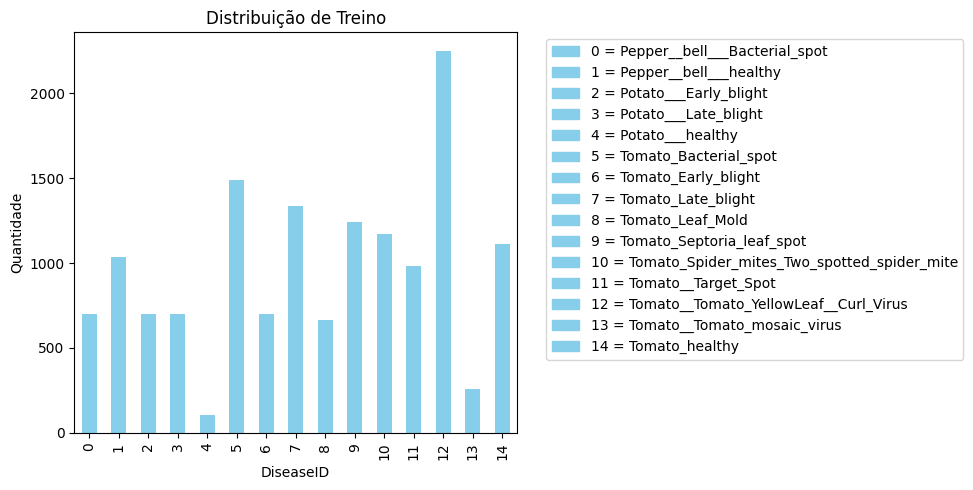

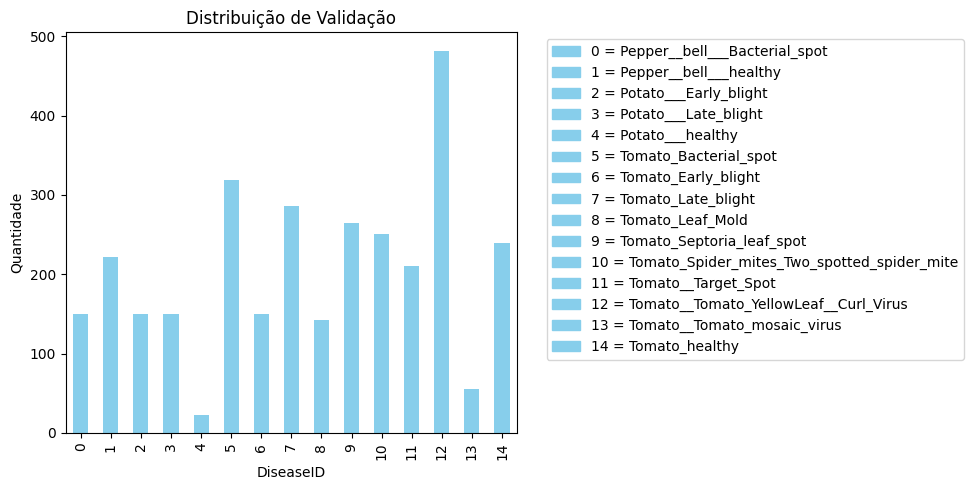

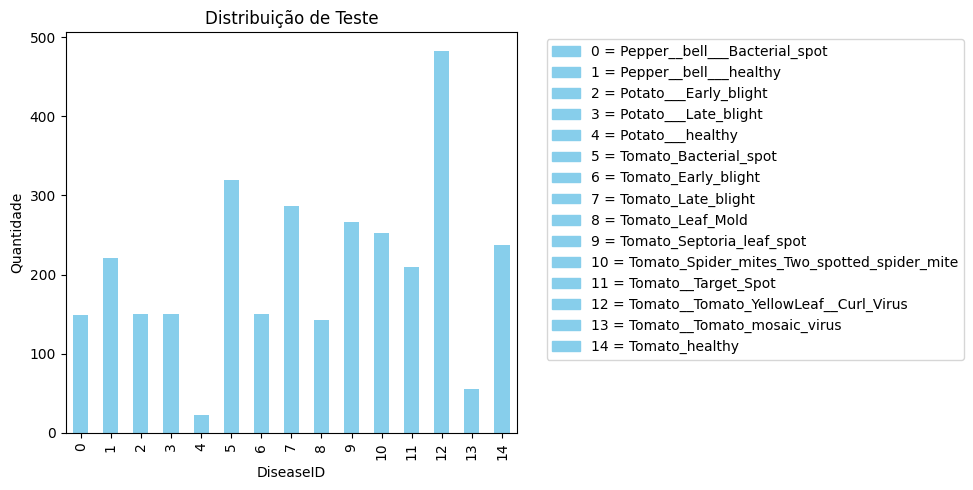

In [ ]:
import matplotlib.pyplot as plt

# =========================
# Visualização de distribuição - Treino, Validação e Teste
# =========================

# Criar mapeamento DiseaseID -> Disease Type (dicionário)
id_to_name = dict(zip(train_df["DiseaseID"], train_df["DiseaseType"]))


def plot_distribution(df, title, filename):
    ax = (
        df["DiseaseID"]
        .value_counts()
        .sort_index()
        .plot(kind="bar", figsize=(10, 5), title=title, color="skyblue")
    )
    ax.set_xlabel("DiseaseID")
    ax.set_ylabel("Quantidade")

    # Criar legenda tipo dicionário
    handles = [plt.Rectangle((0, 0), 1, 1, color="skyblue")] * len(id_to_name)
    labels = [f"{i} = {name}" for i, name in sorted(id_to_name.items())]

    plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()


# Treino
plot_distribution(train_df, "Distribuição de Treino", "distribuicao_treino.png")

# Validação
plot_distribution(val_df, "Distribuição de Validação", "distribuicao_validacao.png")

# Teste
plot_distribution(test_df, "Distribuição de Teste", "distribuicao_teste.png")


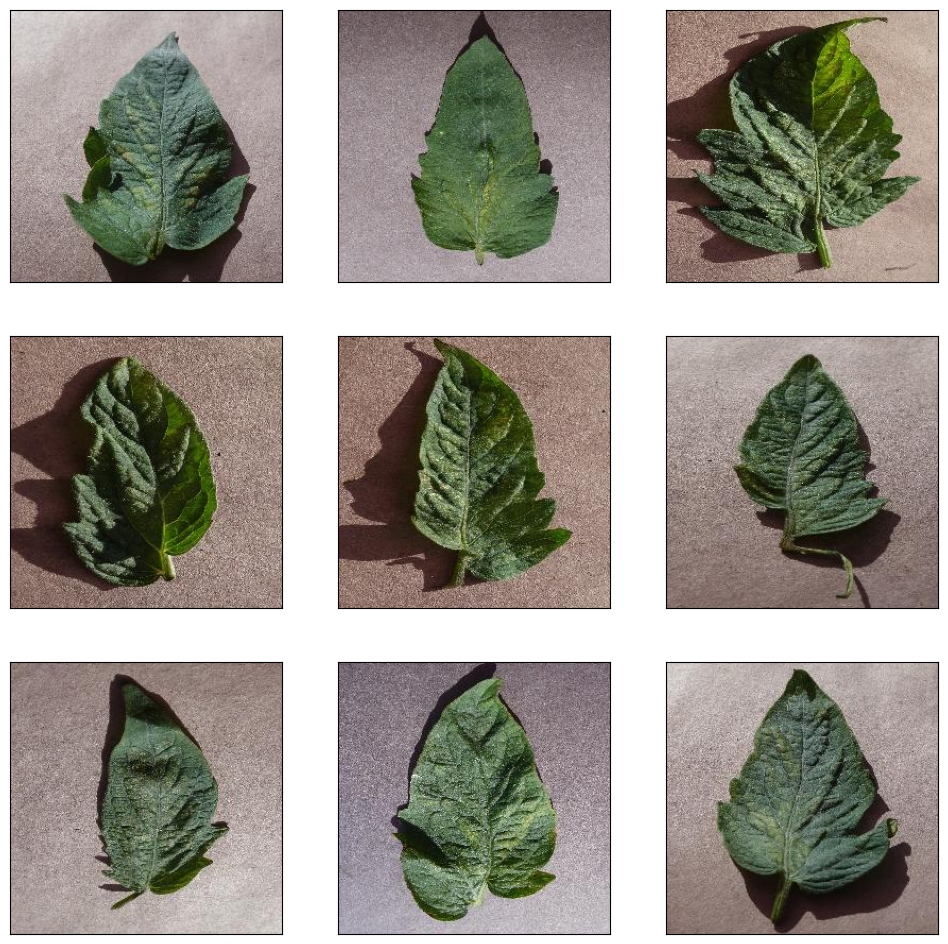

In [ ]:
# =========================
# 6. Função para plotar exemplos
# =========================
def plot_defects(defect_type, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train_df["File"][train_df["DiseaseType"] == defect_type].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            if n >= len(defect_files):
                break
            image_path = defect_files[n]
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax[i, j].imshow(img)
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            n += 1
    plt.show()


# Exemplo
plot_defects("Tomato_Spider_mites_Two_spotted_spider_mite", 3, 3)


In [ ]:
# =========================
# 7. Hiperparâmetros
# =========================
BATCH_SIZE = 64
IMAGE_SIZE = 64
EPOCHS = 50
N_ch = 3


In [ ]:
# =========================
# 8. Data generators
# =========================
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="File",
    y_col="DiseaseType",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="File",
    y_col="DiseaseType",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False,
)


Found 14446 validated image filenames belonging to 15 classes.
Found 3096 validated image filenames belonging to 15 classes.


In [ ]:
# =========================
# 9. Construção do modelo
# =========================
def build_densenet(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, N_ch), n_classes=len(disease_types)
):
    densenet = DenseNet121(
        weights="imagenet", include_top=False, input_shape=input_shape
    )
    x = densenet.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(n_classes, activation="softmax", name="root")(x)
    model = Model(densenet.input, output)
    return model


model = build_densenet()
optimizer = Adam(learning_rate=0.002)
model.compile(
    loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# =========================
# 10. Callbacks
# =========================
annealer = ReduceLROnPlateau(
    monitor="val_accuracy", factor=0.5, patience=5, verbose=1, min_lr=1e-5
)


In [ ]:
# =========================
# 11. Treino
# =========================
history = model.fit(
    train_generator, validation_data=val_generator, epochs=EPOCHS, callbacks=[annealer]
)


c:\Users\EricMochiutti\Desktop\Doutorado-USP\projeto_topicos\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - accuracy: 0.6722 - loss: 1.1015 - val_accuracy: 0.3821 - val_loss: 3.2359 - learning_rate: 0.0020
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.8168 - loss: 0.5794 - val_accuracy: 0.4241 - val_loss: 2.2323 - learning_rate: 0.0020
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - accuracy: 0.8591 - loss: 0.4448 - val_accuracy: 0.2348 - val_loss: 98.3627 - learning_rate: 0.0020
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 308s 1s/step - accuracy: 0.8698 - loss: 0.3979 - val_accuracy: 0.5623 - val_loss: 1.8837 - learning_rate: 0.0020
Epoch 5/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 306s 1s/step - accuracy: 0.9129 - loss: 0.2589 - val_accuracy: 0.6008 - val_loss: 1.9378 - learning_rate: 0.0020
Epoch 6/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.9327 - loss: 0.2062 - val_accuracy: 0.7810 - val_loss: 0.9481 - learning_rate: 0.0020
Epoch 7/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.9344 - loss: 0

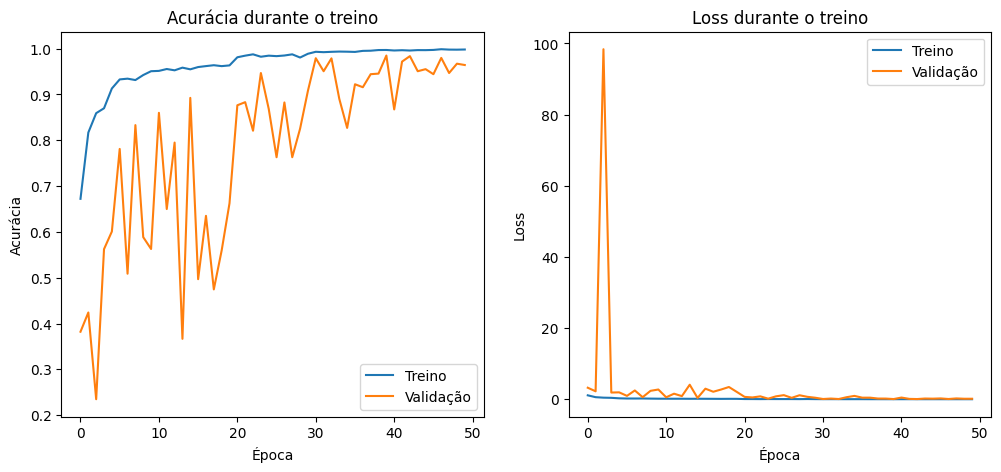

In [79]:
# =========================
# 12. Plot de Loss e Accuracy
# =========================
def plot_training_history(history):
    # Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Treino")
    plt.plot(history.history["val_accuracy"], label="Validação")
    plt.title("Acurácia durante o treino")
    plt.xlabel("Época")
    plt.ylabel("Acurácia")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Treino")
    plt.plot(history.history["val_loss"], label="Validação")
    plt.title("Loss durante o treino")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig("treinamento_rede.jpg", dpi=300, bbox_inches="tight")
    plt.show()


# Chama a função
plot_training_history(history)


49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 296ms/step


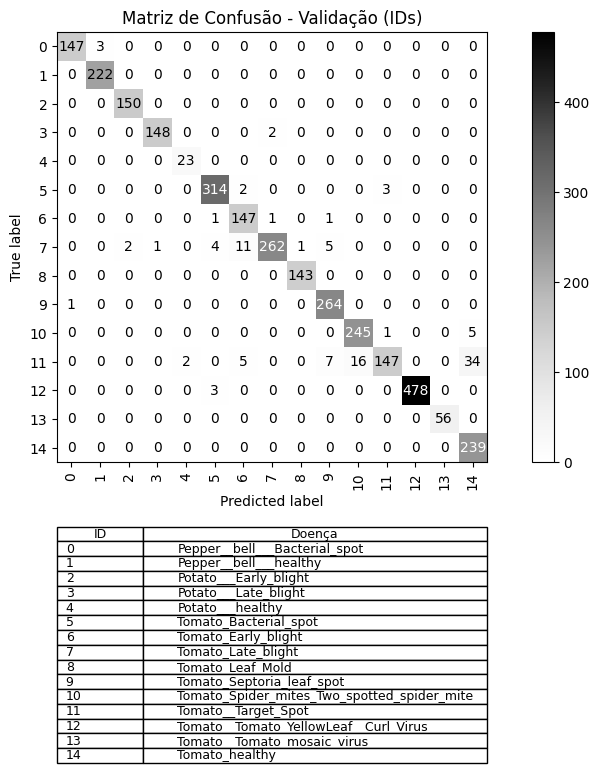

In [96]:
# =========================
# 13. Matriz de Confusão no Conjunto de Validação
# =========================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Faz previsões no conjunto de validação
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Rótulos verdadeiros
y_true = val_generator.classes

# Gera matriz de confusão
cm = confusion_matrix(y_true, y_pred)

# Dicionário {classe: índice} -> invertido {índice: classe}
class_dict = val_generator.class_indices
idx_to_class = {v: k for k, v in class_dict.items()}

# Exibir apenas IDs numéricos no eixo
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=list(idx_to_class.keys())
)

fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(ax=ax, cmap="Greys", values_format="d", xticks_rotation=90, colorbar=True)

plt.title("Matriz de Confusão - Validação (IDs)")

# =========================
# Criar tabela com o dicionário
# =========================
# Prepara dados da tabela
table_data = [[i, name] for i, name in sorted(idx_to_class.items())]

# colWidths: primeira coluna bem estreita (ID), segunda bem larga (Doença)
the_table = plt.table(
    cellText=table_data,
    colLabels=["ID", "Doença"],
    colWidths=[0.2, 0.8],  # <- ajuste chave aqui
    cellLoc="left",
    loc="bottom",
    bbox=[0.0, -0.7, 1.0, 0.55],
)

the_table.auto_set_font_size(False)
the_table.set_fontsize(9)
the_table.scale(1.0, 1.2)  # ajusta altura sem exagero

plt.subplots_adjust(left=0.15, bottom=0.45)  # espaço para a tabela

plt.savefig("matriz_confusao_validacao.png", dpi=300, bbox_inches="tight")
plt.show()


In [97]:
from sklearn.metrics import classification_report

# =========================
# Classification Report
# =========================
# Usar IDs como labels no relatório (em vez dos nomes gigantes)
target_names = [str(i) for i in sorted(idx_to_class.keys())]

report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print("\nClassification Report (Validação):")
print(report)


Classification Report (Validação):
              precision    recall  f1-score   support

           0     0.9932    0.9800    0.9866       150
           1     0.9867    1.0000    0.9933       222
           2     0.9868    1.0000    0.9934       150
           3     0.9933    0.9867    0.9900       150
           4     0.9200    1.0000    0.9583        23
           5     0.9752    0.9843    0.9797       319
           6     0.8909    0.9800    0.9333       150
           7     0.9887    0.9161    0.9510       286
           8     0.9931    1.0000    0.9965       143
           9     0.9531    0.9962    0.9742       265
          10     0.9387    0.9761    0.9570       251
          11     0.9735    0.6967    0.8122       211
          12     1.0000    0.9938    0.9969       481
          13     1.0000    1.0000    1.0000        56
          14     0.8597    1.0000    0.9246       239

    accuracy                         0.9641      3096
   macro avg     0.9635    0.9673    0.9631 

In [72]:
# =========================
# 13. Salvar o modelo
# =========================
model_save_path = os.path.join(model_dir, "densenet_plantvillage.h5")
model.save(model_save_path)
print(f"Modelo salvo em: {model_save_path}")

Modelo salvo em: c:\Users\EricMochiutti\Desktop\Doutorado-USP\projeto_topicos\notebook\..\model\densenet_plantvillage.h5


In [73]:
model_save_path = os.path.join(model_dir, "densenet_plantvillage.keras")
model.save(model_save_path)
print(f"Modelo salvo em: {model_save_path}")

Modelo salvo em: c:\Users\EricMochiutti\Desktop\Doutorado-USP\projeto_topicos\notebook\..\model\densenet_plantvillage.keras


In [74]:
import tensorflow as tf

# Criar o conversor
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model_path = os.path.join(model_dir, "densenet_plantvillage.tflite")
# (Opcional) Otimização para reduzir tamanho ou acelerar
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Converter
tflite_model = converter.convert()

with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"Modelo TFLite salvo em: {tflite_model_path}")

INFO:tensorflow:Assets written to: C:\Users\ERICMO~1\AppData\Local\Temp\tmp67p8wz80\assets


INFO:tensorflow:Assets written to: C:\Users\ERICMO~1\AppData\Local\Temp\tmp67p8wz80\assets


Saved artifact at 'C:\Users\ERICMO~1\AppData\Local\Temp\tmp67p8wz80'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='keras_tensor_362')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  2217036037392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2214899338320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2217036036432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2217036031632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2217036035472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2217036032784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2217036031248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2217036035856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2217036033168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2217036037200: TensorSpec(shape=(), dtype=tf.resource, name=None)
 

In [76]:
test_df

File  \
0     c:\Users\EricMochiutti\Desktop\Doutorado-USP\p...   
1     c:\Users\EricMochiutti\Desktop\Doutorado-USP\p...   
2     c:\Users\EricMochiutti\Desktop\Doutorado-USP\p...   
3     c:\Users\EricMochiutti\Desktop\Doutorado-USP\p...   
4     c:\Users\EricMochiutti\Desktop\Doutorado-USP\p...   
...                                                 ...   
3091  c:\Users\EricMochiutti\Desktop\Doutorado-USP\p...   
3092  c:\Users\EricMochiutti\Desktop\Doutorado-USP\p...   
3093  c:\Users\EricMochiutti\Desktop\Doutorado-USP\p...   
3094  c:\Users\EricMochiutti\Desktop\Doutorado-USP\p...   
3095  c:\Users\EricMochiutti\Desktop\Doutorado-USP\p...   

                                      DiseaseType  DiseaseID  
0                             Tomato__Target_Spot         11  
1                           Potato___Early_blight          2  
2                                  Tomato_healthy         14  
3           Tomato__Tomato_YellowLeaf__Curl_Virus         12  
4                             Tomato__Target_Spot         11  
...                                           ...        ...  
3091                        Potato___Early_blight          2  
3092  Tomato_Spider_mites_Two_spotted_spider_mite         10  
3093                           Tomato_Late_blight          7  
3094                        Potato___Early_blight          2  
3095                  Tomato__Tomato_mosaic_virus         13  

[3096 rows x 3 columns]

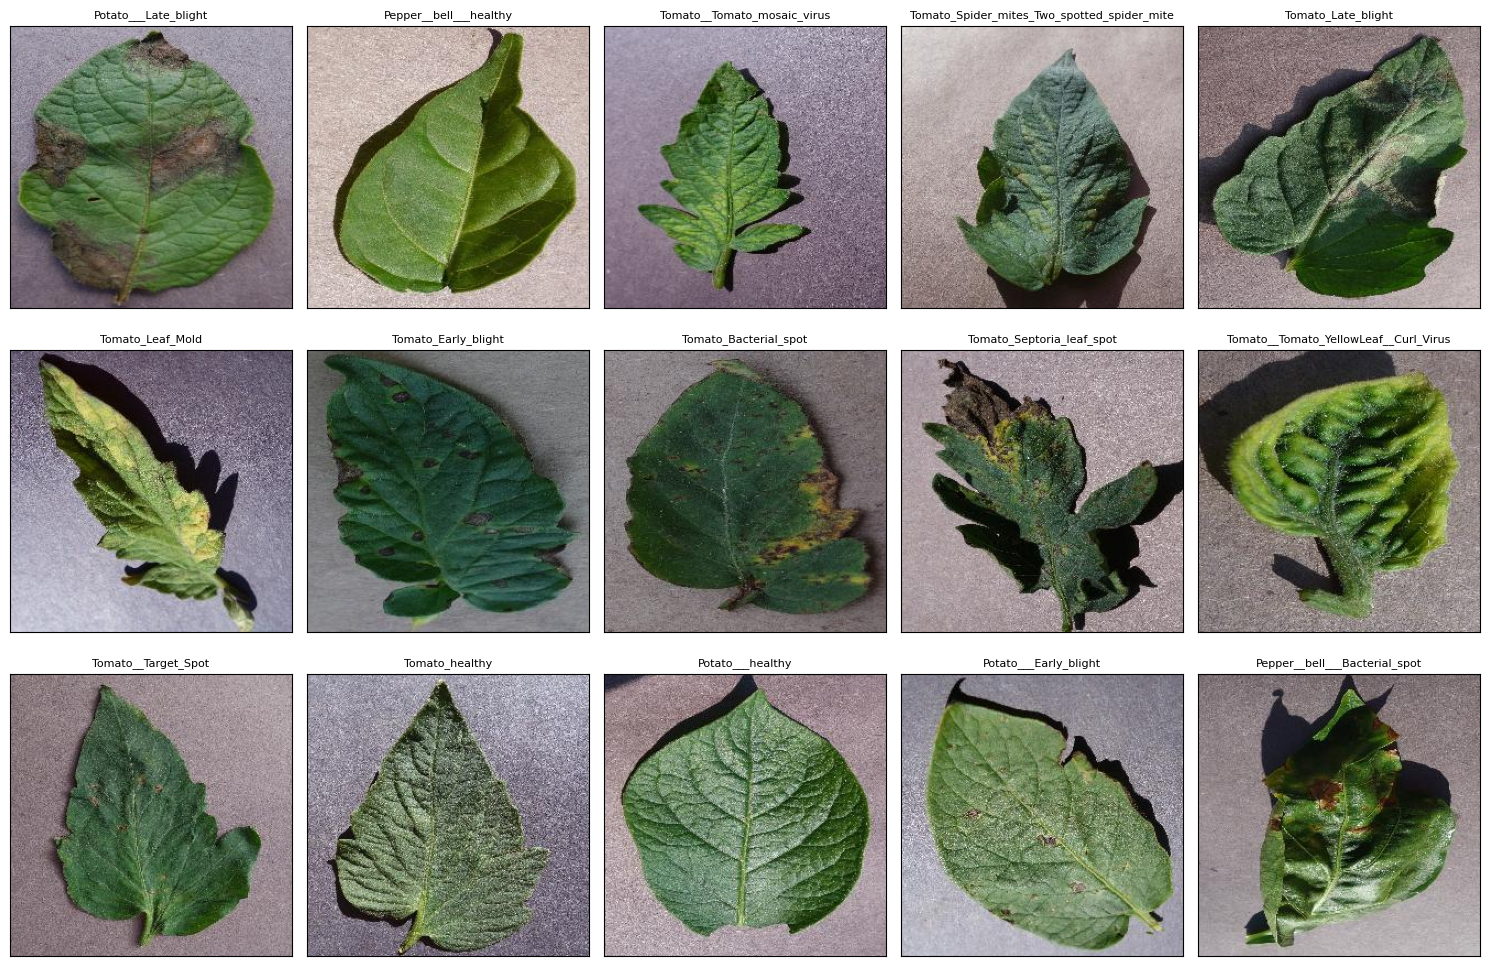

In [ ]:
def plot_all_defects(rows, cols):
    defect_types = train_df["DiseaseType"].unique()
    fig, ax = plt.subplots(rows, cols, figsize=(15, 10))
    ax = ax.ravel()

    for idx, defect_type in enumerate(defect_types[: rows * cols]):
        # pega o primeiro arquivo desse tipo
        defect_files = train_df["File"][train_df["DiseaseType"] == defect_type].values
        if len(defect_files) == 0:
            continue
        image_path = defect_files[0]  # primeira imagem
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax[idx].imshow(img)
        ax[idx].set_title(defect_type, fontsize=8)
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])

    # Remove eixos extras se sobrar espaço
    for k in range(len(defect_types), rows * cols):
        fig.delaxes(ax[k])

    plt.tight_layout()
    plt.savefig("plantas_defeitos.jpg", dpi=300, bbox_inches="tight")
    plt.show()


# Exemplo: 15 labels em 3x5
plot_all_defects(3, 5)